In [2]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


## Data Cleaning Cells:

In [134]:
results_df = pd.read_csv('data/emssubsample.csv')
features = results_df.columns

In [54]:
results_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21320 entries, 0 to 21319
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CAD_INCIDENT_ID                 21320 non-null  int64  
 1   INCIDENT_DATETIME               21320 non-null  object 
 2   INITIAL_CALL_TYPE               21320 non-null  object 
 3   INITIAL_SEVERITY_LEVEL_CODE     21320 non-null  int64  
 4   FINAL_CALL_TYPE                 21320 non-null  object 
 5   FINAL_SEVERITY_LEVEL_CODE       21320 non-null  int64  
 6   FIRST_ASSIGNMENT_DATETIME       21172 non-null  object 
 7   VALID_DISPATCH_RSPNS_TIME_INDC  21320 non-null  object 
 8   DISPATCH_RESPONSE_SECONDS_QY    21320 non-null  int64  
 9   FIRST_ACTIVATION_DATETIME       21101 non-null  object 
 10  FIRST_ON_SCENE_DATETIME         20598 non-null  object 
 11  VALID_INCIDENT_RSPNS_TIME_INDC  21320 non-null  object 
 12  INCIDENT_RESPONSE_SECONDS_QY    

In [135]:
# sort features into type:


features_numeric    = ['CAD_INCIDENT_ID', 'INITIAL_SEVERITY_LEVEL_CODE', 'FINAL_SEVERITY_LEVEL_CODE',
                       'DISPATCH_RESPONSE_SECONDS_QY', 'INCIDENT_RESPONSE_SECONDS_QY', 
                       'INCIDENT_TRAVEL_TM_SECONDS_QY']

features_category   = ['INITIAL_CALL_TYPE', 'FINAL_CALL_TYPE', 'INCIDENT_DISPOSITION_CODE', 'BOROUGH',
                       'INCIDENT_DISPATCH_AREA', 'ZIPCODE', 'POLICEPRECINCT', 'CITYCOUNCILDISTRICT', 
                       'COMMUNITYDISTRICT', 'COMMUNITYSCHOOLDISTRICT', 'CONGRESSIONALDISTRICT']

features_boolean    = ['VALID_DISPATCH_RSPNS_TIME_INDC', 'VALID_INCIDENT_RSPNS_TIME_INDC',
                       'HELD_INDICATOR', 'REOPEN_INDICATOR', 'SPECIAL_EVENT_INDICATOR', 
                       'STANDBY_INDICATOR', 'TRANSFER_INDICATOR']

features_initial    = 'INCIDENT_DATETIME'
features_timestamps = ['FIRST_ASSIGNMENT_DATETIME', 'FIRST_ACTIVATION_DATETIME', 
                       'FIRST_ON_SCENE_DATETIME', 'FIRST_TO_HOSP_DATETIME', 
                       'FIRST_HOSP_ARRIVAL_DATETIME', 'INCIDENT_CLOSE_DATETIME']



In [136]:
# features_numeric: All columns that should be numeric already are.

In [137]:
# features_boolean:

# data has 4 possible values: "Y", "N", "true", "false" (change in way they were inputed?)

# Convert to binary:

for feature in features_boolean:
#    print(feature)
#    print(results_df[feature].value_counts())
    results_df[feature].replace('Y',1,inplace=True)
    results_df[feature].replace('N',0,inplace=True)
    results_df[feature].replace('true',1,inplace=True)
    results_df[feature].replace('false',0,inplace=True)


In [138]:

# categorical data: convert to object then dummify:

for feature in features_category:
    if results_df[feature].dtype != 'object':
        results_df[feature] = results_df[feature].astype(object)

results_df = pd.get_dummies(results_df, columns=features_category,drop_first=True)




In [139]:
# timestamp data columns: From the website, 2021-01-03T23:59:51.000 is "2021 Jan 03 11:59:51 PM"

mon_dict = {1: 'JAN', 2: 'FEB', 3: 'MAR', 4: 'APR', 5: 'MAY', 6: 'JUN',
            7: 'JUL', 8: 'AUG', 9: 'SEP', 10:'OCT', 11:'NOV', 12:'DEC'}
mon_start= {1:0, 2:31, 3:59, 4:90, 5:120, 6:151, 7:181, 8:212, 9:243, 10:273, 11:304, 12:334}

# Get year, month, day, and time of initial call

initial_times = list(results_df[features_initial])
PM = [1 if time_str[20:22]=='PM' else 0 for time_str in initial_times]

call_year  = [pd.to_numeric(time_str[6:10])   for time_str in initial_times]
call_month = [pd.to_numeric(time_str[0:2])    for time_str in initial_times]
call_day   = [pd.to_numeric(time_str[3:5])    for time_str in initial_times]
PM         = [(time_str[20:22]=='PM')         for time_str in initial_times]
hour0      = [pd.to_numeric(time_str[11:13])  for time_str in initial_times]
hour       = np.array([hr+12 if PM[n] else hr         for n,hr in enumerate(hour0)])
minute     = np.array([pd.to_numeric(time_str[14:16]) for time_str in initial_times])
second     = np.array([pd.to_numeric(time_str[17:19]) for time_str in initial_times])
call_time  = hour*3600 + minute*60 + second
results_df['CALL_YEAR']  = call_year
results_df['CALL_MONTH'] = [mon_dict[mn] for mn in call_month]
results_df['CALL_DAY']   = call_day
results_df['CALL_TIME']  = call_time

# dummify the month:
results_df = pd.get_dummies(results_df, columns=['CALL_MONTH'],drop_first=True)
# drop the original timestamp column:
results_df.drop(columns=[features_initial],inplace=True)

In [140]:
# for the rest of the timestamp features, compare to initial time:
for feature in features_timestamps:
    results_df[feature].fillna("missing", inplace = True)

    times = list(results_df[feature])

    # initialize list:
    time_list  = []
    
    # loop through the column:
    for n,time_str in enumerate(list(results_df[feature])):
        if time_str == "missing":
            time_list.append(np.nan)
        else:
            # parse timestamp into yr, mn, day, numeric seconds since midnight:
            year  = pd.to_numeric(time_str[6:10])
            month = pd.to_numeric(time_str[0:2])   
            day   = pd.to_numeric(time_str[3:5])
            hr    = pd.to_numeric(time_str[11:13])
            if time_str[20:22]=='PM': hr += 12
            minute= pd.to_numeric(time_str[14:16])
            sec   = pd.to_numeric(time_str[17:19])
            t     = 3600*hr + 60*minute + sec

            # adjust for calls that run past midnight (and allow for midnight on new years) : 
            mn = call_month[n]
            date0 = mon_start[mn] + call_day[n]
            date = mon_start[month] + day
            t  += (date - date0)*24*3600
            t  += (year-call_year[n])*365*24*3600 
            
            # subtract the call time to get elapsed time in seconds:
            t  -= call_time[n]
            
            # append to list
            time_list.append(t)

    results_df[feature] = time_list



In [141]:
results_df.head()

,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,...,CALL_MONTH_DEC,CALL_MONTH_FEB,CALL_MONTH_JAN,CALL_MONTH_JUL,CALL_MONTH_JUN,CALL_MONTH_MAR,CALL_MONTH_MAY,CALL_MONTH_NOV,CALL_MONTH_OCT,CALL_MONTH_SEP
0,110011884,4,4,9.0,1,9,16.0,480.0,1,480.0,...,0,0,1,0,0,0,0,0,0,0
1,110013013,6,6,28.0,1,28,127.0,674.0,1,674.0,...,0,0,1,0,0,0,0,0,0,0
2,110014121,4,4,10.0,1,10,19.0,399.0,1,399.0,...,0,0,1,0,0,0,0,0,0,0
3,110015204,2,2,16.0,1,16,44.0,272.0,1,272.0,...,0,0,1,0,0,0,0,0,0,0
4,110020794,4,6,27.0,1,27,46.0,920.0,1,920.0,...,0,0,1,0,0,0,0,0,0,0


In [142]:
columns = results_df.columns
d = []
for col in columns:
    nulls = results_df[col].isna().sum()
    d.append({'column': col, 'NULLS': nulls})
chk = pd.DataFrame(d)
chk[chk['NULLS']>0]

,column,NULLS
3,FIRST_ASSIGNMENT_DATETIME,148
6,FIRST_ACTIVATION_DATETIME,219
7,FIRST_ON_SCENE_DATETIME,722
9,INCIDENT_RESPONSE_SECONDS_QY,728
10,INCIDENT_TRAVEL_TM_SECONDS_QY,722
11,FIRST_TO_HOSP_DATETIME,6251
12,FIRST_HOSP_ARRIVAL_DATETIME,6389
13,INCIDENT_CLOSE_DATETIME,4


In [143]:
chk0 = results_df['FIRST_ON_SCENE_DATETIME']-results_df['INCIDENT_RESPONSE_SECONDS_QY']

In [144]:
chk0.min(),chk0.max()

(-43200.0, 43200.0)

In [155]:
12*60*60

43200

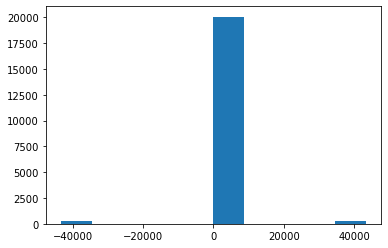

In [145]:
plt.hist(chk0);

In [146]:
np.sum([1 if c!=0 else 0 for c in chk0]), len(chk0)

(1255, 21320)

In [147]:
results_df.shape

(21320, 848)

In [148]:
results_df = results_df[results_df['FIRST_ON_SCENE_DATETIME']==results_df['INCIDENT_RESPONSE_SECONDS_QY']]
results_df.drop(columns = ['FIRST_ON_SCENE_DATETIME'],inplace=True)
results_df.shape

(20065, 847)

In [149]:
columns = results_df.columns
d = []
for col in columns:
    nulls = results_df[col].isna().sum()
    d.append({'column': col, 'NULLS': nulls})
chk = pd.DataFrame(d)
chk[chk['NULLS']>0]

,column,NULLS
6,FIRST_ACTIVATION_DATETIME,37
10,FIRST_TO_HOSP_DATETIME,5563
11,FIRST_HOSP_ARRIVAL_DATETIME,5694
12,INCIDENT_CLOSE_DATETIME,2


That got rid of almost all the NULL values!

In [150]:
results_df.shape

(20065, 847)

In [151]:
results_df.drop(columns = ['FIRST_TO_HOSP_DATETIME', 'FIRST_HOSP_ARRIVAL_DATETIME'], inplace=True)
results_df.dropna(inplace=True)
results_df.shape

(20026, 845)

In [152]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20026 entries, 0 to 21319
Columns: 845 entries, CAD_INCIDENT_ID to CALL_MONTH_SEP
dtypes: float64(5), int64(14), uint8(826)
memory usage: 18.8 MB


In [153]:
results_df.to_csv('./data/emssubsample_clean.csv',index=False)

In [154]:
results_df = pd.read_csv('data/emssubsample_clean.csv')

results_df.head()

,CAD_INCIDENT_ID,INITIAL_SEVERITY_LEVEL_CODE,FINAL_SEVERITY_LEVEL_CODE,FIRST_ASSIGNMENT_DATETIME,VALID_DISPATCH_RSPNS_TIME_INDC,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,VALID_INCIDENT_RSPNS_TIME_INDC,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,...,CALL_MONTH_DEC,CALL_MONTH_FEB,CALL_MONTH_JAN,CALL_MONTH_JUL,CALL_MONTH_JUN,CALL_MONTH_MAR,CALL_MONTH_MAY,CALL_MONTH_NOV,CALL_MONTH_OCT,CALL_MONTH_SEP
0,110011884,4,4,9.0,1,9,16.0,1,480.0,471.0,...,0,0,1,0,0,0,0,0,0,0
1,110013013,6,6,28.0,1,28,127.0,1,674.0,646.0,...,0,0,1,0,0,0,0,0,0,0
2,110014121,4,4,10.0,1,10,19.0,1,399.0,389.0,...,0,0,1,0,0,0,0,0,0,0
3,110015204,2,2,16.0,1,16,44.0,1,272.0,256.0,...,0,0,1,0,0,0,0,0,0,0
4,110020794,4,6,27.0,1,27,46.0,1,920.0,893.0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
results